# Neural network-based model for the identification of Bladder Cancers subtypes

## Induction method

### Pretreatment of the data:
- necessary libraries imports
- dataframe definition
- dataframe sorting and cleaning

In [3]:
# Libraries imports
import os
import torch
os.environ['TORCH'] = torch.__version__
import torch.nn.functional as F
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Dataframe definition
Dataframe_Labels = pd.read_csv("../BLCA_DATA/Workspace/labels_str.csv")          # Contains the labels of each patient (=cancer)
Dataframe_link = pd.read_csv("../BLCA_DATA/Workspace/patient_norm.csv")          # Contains the clinic datas of each patient (will be used for link initialization)
Dataframe_node = pd.read_csv("../BLCA_DATA/Workspace/node_embedding.csv")        # Contains the omic datas of each patient (will be used for node initialization)

# Adding a column to associate each class to a integer
Dataframe_Labels['class_int'], uniques = pd.factorize(Dataframe_Labels['class'])

# Filtering the dataframe to get rid of the two last classes (not enough datas)
Dataframe_Labels = Dataframe_Labels[~Dataframe_Labels['class_int'].isin([4, 5])]

patients_to_keep = Dataframe_Labels['Patient'].unique()
Dataframe_link = Dataframe_link[Dataframe_link['Patient'].isin(patients_to_keep)]
Dataframe_node = Dataframe_node[Dataframe_node['Patient'].isin(patients_to_keep)]

# Reset the labels to get clean Dataframes
Dataframe_Labels = Dataframe_Labels.reset_index(drop=True)
Dataframe_link = Dataframe_link.reset_index(drop=True)
Dataframe_node = Dataframe_node.reset_index(drop=True)
len(Dataframe_Labels)


378

### Graph initialization (weight, nodes and links)

Each weight is defined following this formula :
$$\mu = \text{mean of the number of patient victim of a type of cancer}$$
$$n_i = \text{number of victim of each cancer}$$
$$w_i = \text{weight of the ith class}$$

$$w_i = \frac{\frac{\mu}{n_i}}{\sum \left( \frac{\mu}{n_j} \right)}$$

In [4]:
# class dictionnary 
classes_dict = {0: 'LumP', 
                1: 'Ba/Sq', 
                2: 'LumU', 
                3: 'Stroma-rich'
}

# This function aims at giving weight to each node depending on which cancer the patient has
# It gives the classes contained in the tensor and the weights of each class in the graph
def count_classes_weights(tensor):
    array = tensor.numpy()
    classes_tab = { 0: 0, 
                    1: 0,
                    2: 0, 
                    3: 0
    }
    for i in array:
        classes_tab[i]+=1

    mean_nb_classes = 0
    for i in classes_tab:
        mean_nb_classes += i
    mean_nb_classes *= 1/len(classes_tab)
    
    # normalize the weights
    weight_sum = 0
    for i in range(len(classes_tab)):
        if classes_tab[i] != 0:
            weight_sum += mean_nb_classes / classes_tab[i]
    alpha = 1 / weight_sum

    weight_dict = {}
    used_classes = []
    for i in range(len(classes_tab)):
        if classes_tab[i] != 0:
            weight_dict[i] = alpha * (mean_nb_classes / classes_tab[i]) *50
            used_classes.append(classes_dict[i])

    return used_classes, weight_dict

Nodes and links initialization :

In [5]:
# Definition of the features that will be used to define each node 
node_features = Dataframe_node.drop(columns=['Patient']).values
node_features = torch.tensor(node_features, dtype=torch.float)

# This function aims at creating a Data object that will store the caracteristics of a graph
# It needs:
# - indices (which are the patient wanted in the graph)
# - similarity_threshold (which level of similarity is considered big enough to build a link between two nodes)
# - num_classes (how many classes do we want to identify, default = 4)
def get_data(indices, similarity_threshold, num_classes=4):
    x_data = node_features[indices]

    # Setting a similarity between patients - we use cosine_similarity
    patient_similarity = cosine_similarity(Dataframe_link.iloc[:, 1:])

    # Calculate the edges indexes and attention coefficients
    edge_index = []
    edge_attr = []
    # These will help to reorder the nodes 
    re_indexed_i = 0
    re_indexed_j = 0
    for i in indices:
        for j in indices:
            if i >= j :
                break
            if patient_similarity[i, j] > similarity_threshold:
                edge_index.append([re_indexed_i, re_indexed_j])
                edge_attr.append((patient_similarity[i, j] - similarity_threshold)/(1 - similarity_threshold))
            re_indexed_j +=1
        re_indexed_i +=1
        re_indexed_j = 0

    # Setting the labels of each nodes
    node_labels = Dataframe_Labels["class_int"].values
    labels = torch.tensor(node_labels[indices], dtype=torch.long)

    # Setting the weight
    node_labels = torch.tensor(node_labels, dtype=torch.long)
    used_classes, weight_dict = count_classes_weights(node_labels)
    Dataframe_Labels['weight'] = [weight_dict[x] for x in Dataframe_Labels['class_int']]
    node_weights = torch.tensor(Dataframe_Labels['weight'], dtype=torch.float)

    # Setting the features, connexions (edge_index and edge _attr) and weight of each nodes
    edge_features = torch.tensor(x_data, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.int64).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    node_weights = node_weights[indices]

    # Data object definition
    data = Data(
        x=edge_features,                       # node informations 
        edge_index=edge_index,                 # node connexions (which nodes are connected)
        edge_attr=edge_attr,                   # node connexions (importance of each connexion)
        y=labels,                              # node labels
        weights=node_weights,                  # node weight
        num_classes=num_classes,               # number of classes in the graph
        num_nodes = len(edge_features),        # number of nodes
        num_features = edge_features.shape[1], # number of features
        indices = indices                      # original indices of each nodes (in the dataframe)
    )

    return data


### Graph neural network definition: GATv2

source code available at: https://github.com/tech-srl/how_attentive_are_gats

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from torch_geometric.nn import GATv2Conv
import seaborn as sn

# GATv2 initialization
class GATv2(torch.nn.Module):
    def __init__(self, hidden_channels, heads, data):
        super(GATv2, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GATv2Conv(data.num_features, hidden_channels, heads=heads, edge_dim=1)
        self.conv2 = GATv2Conv(hidden_channels * heads, data.num_classes, edge_dim=1)
        
    def forward(self, x, edge_index, edge_attr):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return x
    
# Entropy loss function
def weighted_cross_entropy_loss(output, target, weights):
    loss = F.cross_entropy(output, target, reduction='none')
    weighted_loss = loss * weights[target]
    return weighted_loss.mean()

# Train function
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = weighted_cross_entropy_loss(out[data.train_mask], data.y[data.train_mask], data.weights[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, model

# Test function
def test(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc, pred[mask]

### Construction of several graphs: Induction method

The induction method consists in building several "small" training graphs and training the model on each one of them. The model will be evaluated on a test graph, separated from the other ones.

In [7]:
from sklearn.model_selection import train_test_split

similarity_threshold = 0.5
test_size = 0.2
n_graphs = 5  # number of graphs used for the training and validation

# Definition of train/val and test indices
train_val_indices, test_indices = train_test_split(
    range(len(node_features)), 
    test_size=test_size, 
    random_state=1234
)

# This function aims at splitting the train/val indices into 5 groups
def split_indices(indices, n_graphs):
    np.random.shuffle(indices)
    return np.array_split(indices, n_graphs)

# Splitting the train/val indices into 5 groups
split_train_val_indices = split_indices(train_val_indices, n_graphs)

# Printing an example 
for i, indices in enumerate(split_train_val_indices):
    print(f"Subset {i+1}: {indices}, {len(indices)}")


Subset 1: [114 277 216 254 357 290 200 229  20  26 201 231 251 317 244 141   1  93
  83 263  60 276 208 308 145 147 242  10 369  87 186 155 287   6  75 269
   9 136  48 318 139 365  58 343 328 158 157  50  42 183 240 218 159  63
 150 316 199 197 285 162  23], 61
Subset 2: [299 161  28  72 249 190 235 206  52  18 160 174 334 323  14 256 156  62
 255 181 348 362 179 203 342 265 187 327 326  96  38 332 312 298 121 234
  79 143 275  11 336 245 331 195  85  35  61 117 284  27  19 288  69 363
  40  53 325  57 142  74 377], 61
Subset 3: [116 373  56 215  84 375 267 341   3 282 153 294  30 106 319  81  89 148
  25 304 224 109 137 372 324  94  88 261 213 144  82 247 191 356 350 125
  34  17 110 225 253 311 172  46 127 152  12 131  31 353 281 173 376   5
 278 182 246 118 280 358], 60
Subset 4: [227  80 303 193  16 374 112 128 126 105 274  39 122 264 359 371 123  78
 132 185 211 310 194 151 349 214 260 171   4 175   0   2 291 167 305 259
 313 337 177 346   8 165  76 209 295 135 233 196 366  77 30

In [8]:
def cross_validation_induction(data, k_folds, hidden_channels, heads, num_epochs=1000, n_graphs=5):

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=1234)

    # Create folds for building a more robust model
    for fold, (_, _) in enumerate(skf.split(data.x, data.y)):

        all_val_acc = []
        lost_function_compil = []
        all_val_acc_plot = []
        mean_val_acc_graph = 0

        # Predicted and true labels for plotting the confusion matrix
        y_pred_list = []
        y_true_list = []
        
        # Splitting the training data
        split_train_val_indices = split_indices(data.indices, n_graphs)
        # The index of the graph the model is currently working on 
        graph = 1
        # Initialization of the model
        data_graph = get_data(split_train_val_indices[0], similarity_threshold, num_classes=4)
        model = GATv2(hidden_channels=hidden_channels, heads=heads, data=data_graph)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

        # Training step on each graph
        for node_in_each_graph in split_train_val_indices:

            data_graph = get_data(node_in_each_graph, similarity_threshold, num_classes=4)

            # Splitting the small graph in two for training and validation
            train_index, val_index = train_test_split(
                range(len(node_in_each_graph)), 
                test_size=0.2, 
                random_state=1234
            )

            # Define masks
            data_graph.train_mask = torch.zeros(data_graph.num_nodes, dtype=torch.bool)
            data_graph.train_mask[train_index] = True
            
            data_graph.val_mask = torch.zeros(data_graph.num_nodes, dtype=torch.bool)
            data_graph.val_mask[val_index] = True

            # Training loop
            for epoch in range(1, num_epochs):
                loss, model = train(model, data_graph, optimizer)
                train_acc, _ = test (model, data_graph, data_graph.train_mask)
                val_acc, _ = test(model, data_graph, data_graph.val_mask)
                lost_function_compil.append(loss.detach().tolist())
                all_val_acc_plot.append(val_acc)
                if epoch % 50 == 0:
                    print(f'Graph: {graph}, Fold: {fold + 1}, Epoch: {epoch:03d}, Loss: {loss:.4f}, Train_acc {train_acc:.4f}, Val_acc {val_acc:.4f}')
            graph += 1

            # Evaluate on validation set
            val_acc, y_pred = test(model, data_graph, data_graph.val_mask)
            y_true = data_graph.y[data_graph.val_mask]

            y_pred_list.append(y_pred)
            y_true_list.append(y_true)
            mean_val_acc_graph += val_acc

        mean_val_acc_graph *= 1 / n_graphs

        # Setting the best model through the folds
        if val_acc > mean_val_acc_graph:
            best_model = model

        concatenated_y_pred = torch.cat(y_pred_list, dim=0)
        concatenated_y_true = torch.cat(y_true_list, dim=0)

        # Store results
        all_val_acc.append(val_acc)

        # Plot the confusion matrix
        conf_matrix = confusion_matrix(concatenated_y_true.cpu().tolist(), concatenated_y_pred.cpu().tolist())
        labels=['LumP', 'Ba/Sq', 'LumU', 'Stroma-rich']
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        df_cm = pd.DataFrame(conf_matrix_normalized, index=labels, columns=labels)  
        sn.heatmap(df_cm, annot=True)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix on Validation')
        plt.show()

        # Plot the loss function and the accuracy improvement
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        ax1.plot(range(len(lost_function_compil)), lost_function_compil, label='Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss Function over Epochs')
        ax1.legend()

        ax2.plot(range(len(all_val_acc_plot)), all_val_acc_plot, label='val_accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('val_accuracy')
        ax2.set_title('val_accuracy over Epochs')
        ax2.legend()

        plt.show()

    # Calculate and print overall metrics
    mean_val_acc = np.mean(all_val_acc)
    std_val_acc = np.std(all_val_acc)
    print(f'Mean Validation Accuracy: {mean_val_acc:.4f}, Std Validation Accuracy: {std_val_acc:.4f}')

    return best_model, mean_val_acc

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

Graph: 1, Fold: 1, Epoch: 050, Loss: 3.4667, Train_acc 0.8333, Val_acc 0.9231
Graph: 1, Fold: 1, Epoch: 100, Loss: 2.8544, Train_acc 0.8958, Val_acc 0.9231
Graph: 1, Fold: 1, Epoch: 150, Loss: 1.2311, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 1, Epoch: 200, Loss: 0.5446, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 1, Epoch: 250, Loss: 1.2510, Train_acc 1.0000, Val_acc 0.9231
Graph: 1, Fold: 1, Epoch: 300, Loss: 0.7321, Train_acc 1.0000, Val_acc 0.9231
Graph: 1, Fold: 1, Epoch: 350, Loss: 0.2254, Train_acc 1.0000, Val_acc 0.9231
Graph: 1, Fold: 1, Epoch: 400, Loss: 0.6612, Train_acc 1.0000, Val_acc 1.0000
Graph: 1, Fold: 1, Epoch: 450, Loss: 0.6956, Train_acc 1.0000, Val_acc 0.9231
Graph: 1, Fold: 1, Epoch: 500, Loss: 0.2913, Train_acc 1.0000, Val_acc 0.9231
Graph: 1, Fold: 1, Epoch: 550, Loss: 0.1821, Train_acc 1.0000, Val_acc 0.9231
Graph: 1, Fold: 1, Epoch: 600, Loss: 0.4096, Train_acc 1.0000, Val_acc 0.9231
Graph: 1, Fold: 1, Epoch: 650, Loss: 0.5690, Train_acc 1.0000, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 2, Fold: 1, Epoch: 050, Loss: 3.7383, Train_acc 0.7917, Val_acc 0.8462
Graph: 2, Fold: 1, Epoch: 100, Loss: 2.9456, Train_acc 0.9375, Val_acc 0.8462
Graph: 2, Fold: 1, Epoch: 150, Loss: 2.2247, Train_acc 0.9167, Val_acc 0.9231
Graph: 2, Fold: 1, Epoch: 200, Loss: 2.0078, Train_acc 0.9583, Val_acc 0.9231
Graph: 2, Fold: 1, Epoch: 250, Loss: 1.1332, Train_acc 0.9792, Val_acc 1.0000
Graph: 2, Fold: 1, Epoch: 300, Loss: 1.0419, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 1, Epoch: 350, Loss: 0.8473, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 1, Epoch: 400, Loss: 2.4069, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 1, Epoch: 450, Loss: 0.5962, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 1, Epoch: 500, Loss: 1.0569, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 1, Epoch: 550, Loss: 0.5531, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 1, Epoch: 600, Loss: 0.0709, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 1, Epoch: 650, Loss: 0.4636, Train_acc 1.0000, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 3, Fold: 1, Epoch: 050, Loss: 2.5128, Train_acc 0.9583, Val_acc 0.9167
Graph: 3, Fold: 1, Epoch: 100, Loss: 2.4702, Train_acc 0.9583, Val_acc 0.9167
Graph: 3, Fold: 1, Epoch: 150, Loss: 0.7700, Train_acc 0.9792, Val_acc 0.9167
Graph: 3, Fold: 1, Epoch: 200, Loss: 0.7544, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 1, Epoch: 250, Loss: 0.9826, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 1, Epoch: 300, Loss: 0.7641, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 1, Epoch: 350, Loss: 0.2439, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 1, Epoch: 400, Loss: 0.8708, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 1, Epoch: 450, Loss: 0.4850, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 1, Epoch: 500, Loss: 0.3369, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 1, Epoch: 550, Loss: 0.8468, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 1, Epoch: 600, Loss: 0.1590, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 1, Epoch: 650, Loss: 0.3993, Train_acc 1.0000, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 4, Fold: 1, Epoch: 050, Loss: 0.7322, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 100, Loss: 0.1805, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 150, Loss: 0.1235, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 200, Loss: 0.4338, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 250, Loss: 0.3131, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 300, Loss: 0.0363, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 350, Loss: 0.0730, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 400, Loss: 0.6541, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 450, Loss: 0.0555, Train_acc 1.0000, Val_acc 0.9167
Graph: 4, Fold: 1, Epoch: 500, Loss: 0.1484, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 550, Loss: 0.0702, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 600, Loss: 0.0722, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 650, Loss: 0.0547, Train_acc 1.0000, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 5, Fold: 1, Epoch: 050, Loss: 0.0261, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 1, Epoch: 100, Loss: 0.0425, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 1, Epoch: 150, Loss: 0.0102, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 1, Epoch: 200, Loss: 0.3635, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 1, Epoch: 250, Loss: 0.0158, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 1, Epoch: 300, Loss: 0.2128, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 1, Epoch: 350, Loss: 0.0020, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 1, Epoch: 400, Loss: 0.0088, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 1, Epoch: 450, Loss: 0.4367, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 1, Epoch: 500, Loss: 1.8829, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 1, Epoch: 550, Loss: 0.0385, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 1, Epoch: 600, Loss: 0.0167, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 1, Epoch: 650, Loss: 0.0201, Train_acc 1.0000, V

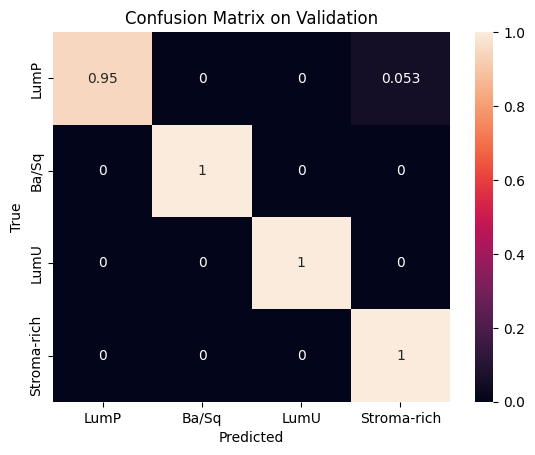

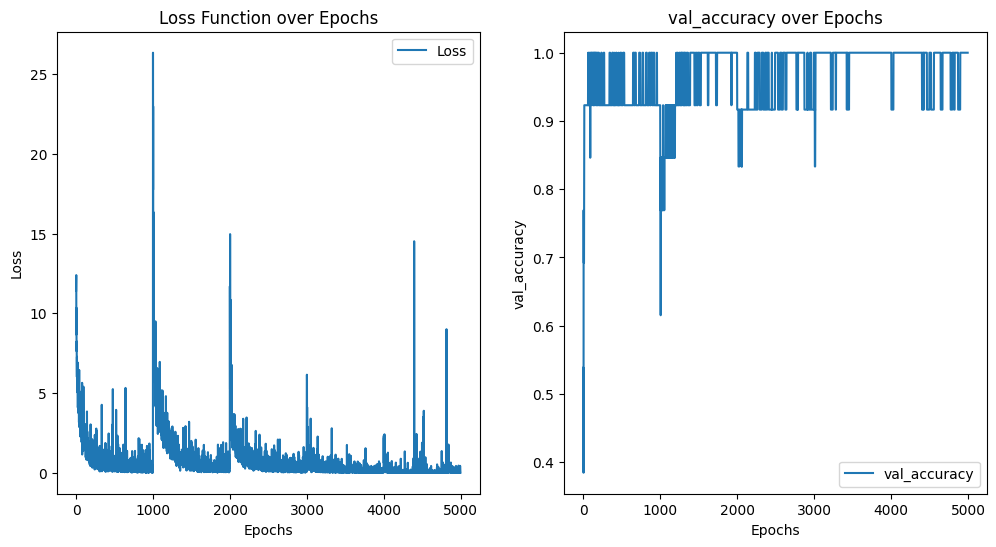

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 1, Fold: 2, Epoch: 050, Loss: 7.1541, Train_acc 0.7500, Val_acc 0.7692
Graph: 1, Fold: 2, Epoch: 100, Loss: 5.6391, Train_acc 0.8542, Val_acc 0.9231
Graph: 1, Fold: 2, Epoch: 150, Loss: 4.6362, Train_acc 0.8750, Val_acc 1.0000
Graph: 1, Fold: 2, Epoch: 200, Loss: 5.7977, Train_acc 0.8750, Val_acc 1.0000
Graph: 1, Fold: 2, Epoch: 250, Loss: 3.2691, Train_acc 0.8750, Val_acc 1.0000
Graph: 1, Fold: 2, Epoch: 300, Loss: 2.6348, Train_acc 0.9375, Val_acc 1.0000
Graph: 1, Fold: 2, Epoch: 350, Loss: 2.5153, Train_acc 0.9375, Val_acc 1.0000
Graph: 1, Fold: 2, Epoch: 400, Loss: 1.9883, Train_acc 0.9375, Val_acc 1.0000
Graph: 1, Fold: 2, Epoch: 450, Loss: 2.1386, Train_acc 0.9167, Val_acc 0.9231
Graph: 1, Fold: 2, Epoch: 500, Loss: 1.6450, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 2, Epoch: 550, Loss: 1.0630, Train_acc 1.0000, Val_acc 1.0000
Graph: 1, Fold: 2, Epoch: 600, Loss: 1.1396, Train_acc 1.0000, Val_acc 1.0000
Graph: 1, Fold: 2, Epoch: 650, Loss: 0.6672, Train_acc 1.0000, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 2, Fold: 2, Epoch: 050, Loss: 4.9258, Train_acc 0.9375, Val_acc 0.7692
Graph: 2, Fold: 2, Epoch: 100, Loss: 3.0188, Train_acc 0.9375, Val_acc 0.8462
Graph: 2, Fold: 2, Epoch: 150, Loss: 1.2317, Train_acc 0.9375, Val_acc 0.9231
Graph: 2, Fold: 2, Epoch: 200, Loss: 1.4245, Train_acc 0.9583, Val_acc 0.8462
Graph: 2, Fold: 2, Epoch: 250, Loss: 1.2656, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 2, Epoch: 300, Loss: 0.7484, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 2, Epoch: 350, Loss: 0.4675, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 2, Epoch: 400, Loss: 0.9640, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 2, Epoch: 450, Loss: 0.4281, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 2, Epoch: 500, Loss: 0.4555, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 2, Epoch: 550, Loss: 0.3263, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 2, Epoch: 600, Loss: 3.2341, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 2, Epoch: 650, Loss: 0.5425, Train_acc 1.0000, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 3, Fold: 2, Epoch: 050, Loss: 0.4242, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 100, Loss: 0.3472, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 150, Loss: 0.3405, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 200, Loss: 1.0460, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 250, Loss: 0.1390, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 300, Loss: 0.9611, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 350, Loss: 0.0258, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 400, Loss: 0.0165, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 450, Loss: 0.0764, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 500, Loss: 0.2798, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 550, Loss: 0.3228, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 600, Loss: 0.1225, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 650, Loss: 0.0271, Train_acc 1.0000, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 4, Fold: 2, Epoch: 050, Loss: 0.0352, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 2, Epoch: 100, Loss: 0.0130, Train_acc 1.0000, Val_acc 0.9167
Graph: 4, Fold: 2, Epoch: 150, Loss: 0.1743, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 2, Epoch: 200, Loss: 0.0114, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 2, Epoch: 250, Loss: 0.1156, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 2, Epoch: 300, Loss: 0.0081, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 2, Epoch: 350, Loss: 0.0222, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 2, Epoch: 400, Loss: 0.0079, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 2, Epoch: 450, Loss: 0.7949, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 2, Epoch: 500, Loss: 0.0023, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 2, Epoch: 550, Loss: 0.1383, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 2, Epoch: 600, Loss: 0.0140, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 2, Epoch: 650, Loss: 0.1715, Train_acc 1.0000, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 5, Fold: 2, Epoch: 050, Loss: 1.1657, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 100, Loss: 0.6163, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 150, Loss: 0.2588, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 200, Loss: 0.6796, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 250, Loss: 0.1796, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 300, Loss: 0.0487, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 350, Loss: 0.4168, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 400, Loss: 0.0382, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 450, Loss: 0.0800, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 500, Loss: 0.0375, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 550, Loss: 0.0200, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 600, Loss: 0.0036, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 650, Loss: 0.0301, Train_acc 1.0000, V

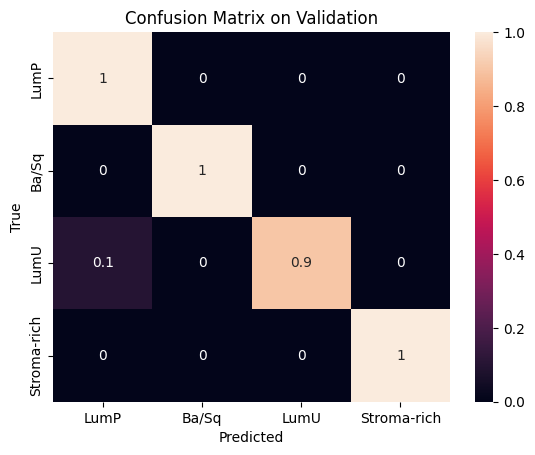

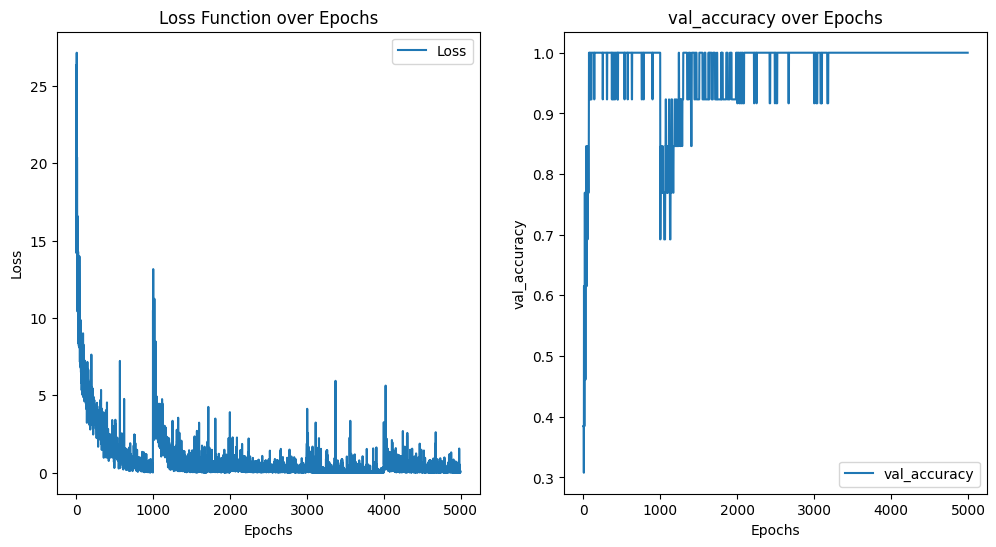

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 1, Fold: 3, Epoch: 050, Loss: 6.6907, Train_acc 0.7083, Val_acc 0.4615
Graph: 1, Fold: 3, Epoch: 100, Loss: 7.5848, Train_acc 0.7500, Val_acc 0.4615
Graph: 1, Fold: 3, Epoch: 150, Loss: 6.1448, Train_acc 0.7292, Val_acc 0.3846
Graph: 1, Fold: 3, Epoch: 200, Loss: 6.3702, Train_acc 0.7708, Val_acc 0.5385
Graph: 1, Fold: 3, Epoch: 250, Loss: 6.6305, Train_acc 0.7917, Val_acc 0.6154
Graph: 1, Fold: 3, Epoch: 300, Loss: 4.0530, Train_acc 0.6667, Val_acc 0.3077
Graph: 1, Fold: 3, Epoch: 350, Loss: 4.2214, Train_acc 0.8958, Val_acc 0.6154
Graph: 1, Fold: 3, Epoch: 400, Loss: 2.8531, Train_acc 0.7292, Val_acc 0.3846
Graph: 1, Fold: 3, Epoch: 450, Loss: 3.0818, Train_acc 0.8958, Val_acc 0.6154
Graph: 1, Fold: 3, Epoch: 500, Loss: 1.6411, Train_acc 0.9583, Val_acc 0.6923
Graph: 1, Fold: 3, Epoch: 550, Loss: 1.5960, Train_acc 0.9583, Val_acc 0.6154
Graph: 1, Fold: 3, Epoch: 600, Loss: 1.4702, Train_acc 0.9792, Val_acc 0.7692
Graph: 1, Fold: 3, Epoch: 650, Loss: 1.5024, Train_acc 0.9792, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 2, Fold: 3, Epoch: 050, Loss: 1.4351, Train_acc 0.9792, Val_acc 0.9231
Graph: 2, Fold: 3, Epoch: 100, Loss: 0.9438, Train_acc 0.9792, Val_acc 0.9231
Graph: 2, Fold: 3, Epoch: 150, Loss: 1.5817, Train_acc 0.9792, Val_acc 0.9231
Graph: 2, Fold: 3, Epoch: 200, Loss: 0.1686, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 3, Epoch: 250, Loss: 0.5690, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 3, Epoch: 300, Loss: 0.4556, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 3, Epoch: 350, Loss: 1.7184, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 3, Epoch: 400, Loss: 0.2667, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 3, Epoch: 450, Loss: 0.7843, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 3, Epoch: 500, Loss: 0.5305, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 3, Epoch: 550, Loss: 0.1058, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 3, Epoch: 600, Loss: 0.3007, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 3, Epoch: 650, Loss: 0.1005, Train_acc 1.0000, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 3, Fold: 3, Epoch: 050, Loss: 0.3362, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 3, Epoch: 100, Loss: 1.1438, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 3, Epoch: 150, Loss: 0.3027, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 200, Loss: 0.1605, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 250, Loss: 0.9967, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 300, Loss: 0.5831, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 350, Loss: 0.7817, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 400, Loss: 0.1345, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 450, Loss: 0.7159, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 500, Loss: 0.1016, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 550, Loss: 0.1274, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 600, Loss: 0.0275, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 650, Loss: 0.3741, Train_acc 1.0000, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 4, Fold: 3, Epoch: 050, Loss: 0.3605, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 100, Loss: 0.0345, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 150, Loss: 0.0437, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 200, Loss: 0.1360, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 250, Loss: 0.0899, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 300, Loss: 0.0110, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 350, Loss: 0.3664, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 400, Loss: 0.0357, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 450, Loss: 0.0752, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 500, Loss: 0.1208, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 550, Loss: 0.0066, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 600, Loss: 0.5572, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 650, Loss: 0.2925, Train_acc 1.0000, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 5, Fold: 3, Epoch: 050, Loss: 0.6905, Train_acc 1.0000, Val_acc 0.8333
Graph: 5, Fold: 3, Epoch: 100, Loss: 0.8993, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 3, Epoch: 150, Loss: 2.1966, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 200, Loss: 0.0594, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 250, Loss: 0.7725, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 300, Loss: 0.2902, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 350, Loss: 0.1385, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 3, Epoch: 400, Loss: 0.1602, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 450, Loss: 0.1576, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 500, Loss: 0.0962, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 3, Epoch: 550, Loss: 0.0816, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 600, Loss: 0.0138, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 650, Loss: 0.1597, Train_acc 1.0000, V

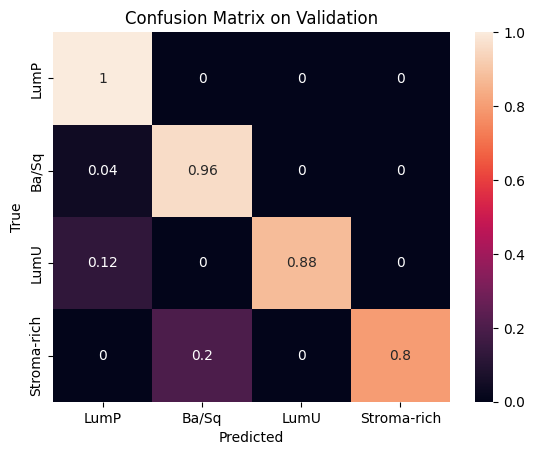

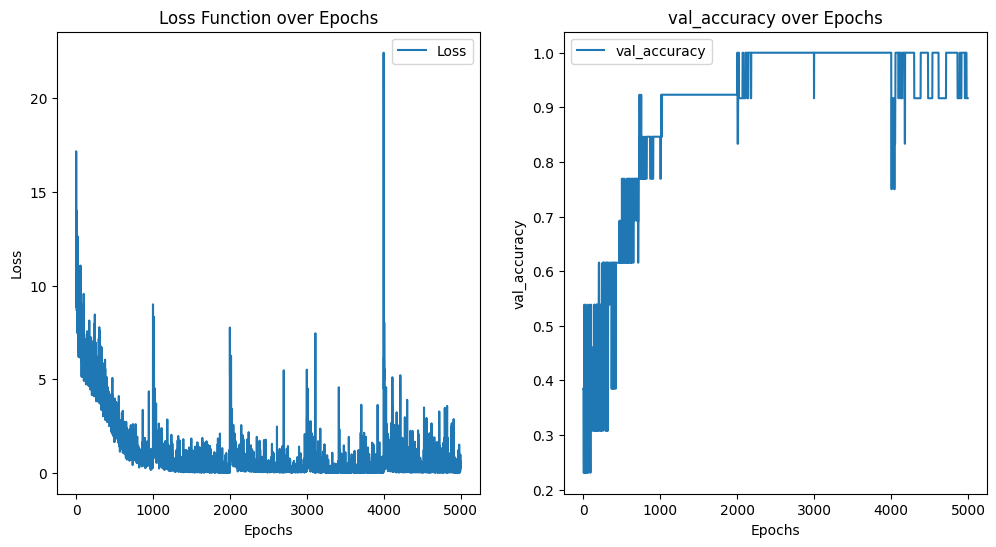

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 1, Fold: 4, Epoch: 050, Loss: 9.2078, Train_acc 0.7917, Val_acc 0.5385
Graph: 1, Fold: 4, Epoch: 100, Loss: 6.4195, Train_acc 0.8333, Val_acc 0.8462
Graph: 1, Fold: 4, Epoch: 150, Loss: 6.1656, Train_acc 0.8542, Val_acc 0.7692
Graph: 1, Fold: 4, Epoch: 200, Loss: 4.2834, Train_acc 0.8750, Val_acc 0.7692
Graph: 1, Fold: 4, Epoch: 250, Loss: 4.2913, Train_acc 0.8750, Val_acc 0.8462
Graph: 1, Fold: 4, Epoch: 300, Loss: 4.0666, Train_acc 0.8958, Val_acc 0.8462
Graph: 1, Fold: 4, Epoch: 350, Loss: 3.2467, Train_acc 0.8958, Val_acc 0.9231
Graph: 1, Fold: 4, Epoch: 400, Loss: 4.7244, Train_acc 0.8750, Val_acc 0.7692
Graph: 1, Fold: 4, Epoch: 450, Loss: 4.2149, Train_acc 0.9167, Val_acc 0.9231
Graph: 1, Fold: 4, Epoch: 500, Loss: 2.6392, Train_acc 0.9792, Val_acc 0.9231
Graph: 1, Fold: 4, Epoch: 550, Loss: 1.3878, Train_acc 1.0000, Val_acc 0.9231
Graph: 1, Fold: 4, Epoch: 600, Loss: 1.9767, Train_acc 1.0000, Val_acc 0.9231
Graph: 1, Fold: 4, Epoch: 650, Loss: 1.4446, Train_acc 1.0000, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 2, Fold: 4, Epoch: 050, Loss: 2.0251, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 4, Epoch: 100, Loss: 1.5118, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 4, Epoch: 150, Loss: 0.3167, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 4, Epoch: 200, Loss: 0.3640, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 4, Epoch: 250, Loss: 0.4026, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 4, Epoch: 300, Loss: 0.5730, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 4, Epoch: 350, Loss: 0.9311, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 4, Epoch: 400, Loss: 0.3617, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 4, Epoch: 450, Loss: 0.2212, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 4, Epoch: 500, Loss: 0.6442, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 4, Epoch: 550, Loss: 0.1220, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 4, Epoch: 600, Loss: 0.0447, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 4, Epoch: 650, Loss: 0.7212, Train_acc 1.0000, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 3, Fold: 4, Epoch: 050, Loss: 1.4529, Train_acc 0.9792, Val_acc 1.0000
Graph: 3, Fold: 4, Epoch: 100, Loss: 0.2883, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 4, Epoch: 150, Loss: 0.7000, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 4, Epoch: 200, Loss: 1.5781, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 4, Epoch: 250, Loss: 0.8221, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 4, Epoch: 300, Loss: 1.0722, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 4, Epoch: 350, Loss: 4.0161, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 4, Epoch: 400, Loss: 0.0320, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 4, Epoch: 450, Loss: 0.0837, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 4, Epoch: 500, Loss: 0.9749, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 4, Epoch: 550, Loss: 0.0916, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 4, Epoch: 600, Loss: 0.0581, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 4, Epoch: 650, Loss: 0.1240, Train_acc 1.0000, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 4, Fold: 4, Epoch: 050, Loss: 2.3627, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 100, Loss: 1.0911, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 150, Loss: 3.1049, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 200, Loss: 0.2284, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 250, Loss: 0.4543, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 300, Loss: 0.0217, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 350, Loss: 0.0478, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 400, Loss: 0.2975, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 450, Loss: 0.1962, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 500, Loss: 1.0781, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 550, Loss: 0.1123, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 600, Loss: 0.1317, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 650, Loss: 0.2074, Train_acc 1.0000, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 5, Fold: 4, Epoch: 050, Loss: 0.8906, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 100, Loss: 0.1521, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 150, Loss: 1.1804, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 200, Loss: 0.6862, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 250, Loss: 0.1226, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 300, Loss: 0.8983, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 350, Loss: 0.7215, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 400, Loss: 1.0754, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 450, Loss: 0.4502, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 500, Loss: 0.1743, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 550, Loss: 0.0813, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 600, Loss: 0.1147, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 650, Loss: 0.0158, Train_acc 1.0000, V

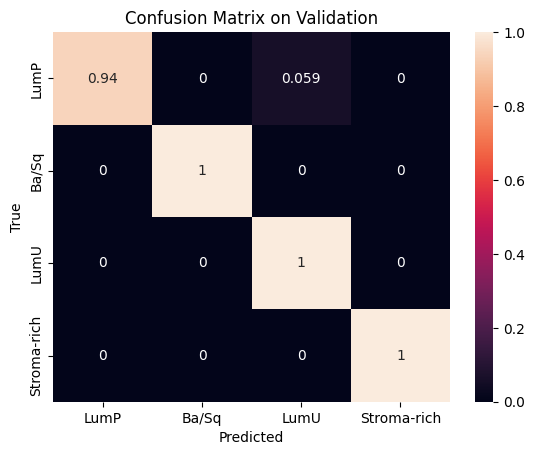

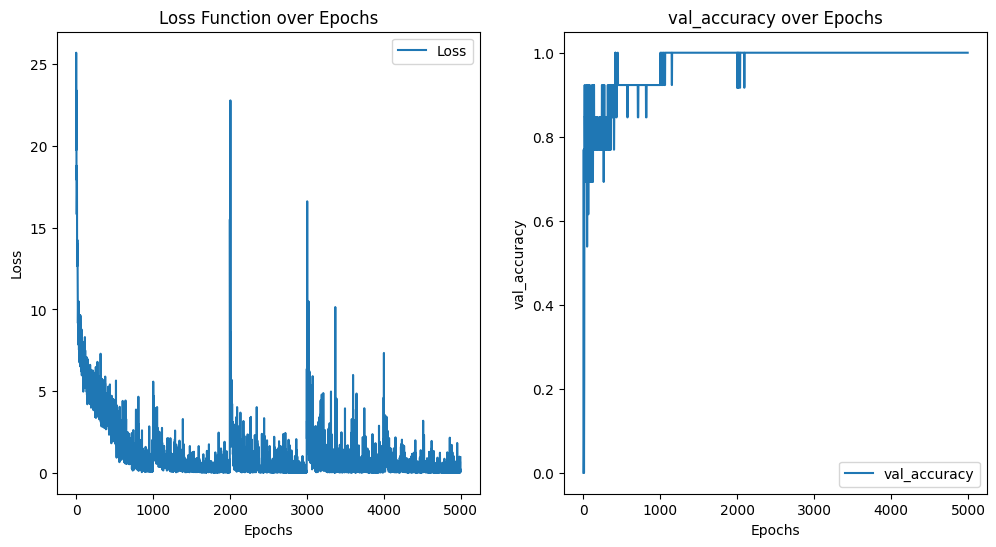

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 1, Fold: 5, Epoch: 050, Loss: 8.1345, Train_acc 0.5417, Val_acc 0.5385
Graph: 1, Fold: 5, Epoch: 100, Loss: 11.1995, Train_acc 0.5833, Val_acc 0.6154
Graph: 1, Fold: 5, Epoch: 150, Loss: 9.3343, Train_acc 0.5417, Val_acc 0.6923
Graph: 1, Fold: 5, Epoch: 200, Loss: 6.2401, Train_acc 0.7708, Val_acc 0.6923
Graph: 1, Fold: 5, Epoch: 250, Loss: 4.9245, Train_acc 0.6875, Val_acc 0.7692
Graph: 1, Fold: 5, Epoch: 300, Loss: 8.4517, Train_acc 0.8750, Val_acc 0.7692
Graph: 1, Fold: 5, Epoch: 350, Loss: 4.2519, Train_acc 0.8750, Val_acc 0.7692
Graph: 1, Fold: 5, Epoch: 400, Loss: 2.8848, Train_acc 0.8958, Val_acc 0.8462
Graph: 1, Fold: 5, Epoch: 450, Loss: 2.6352, Train_acc 0.9167, Val_acc 0.8462
Graph: 1, Fold: 5, Epoch: 500, Loss: 2.9707, Train_acc 0.9375, Val_acc 0.8462
Graph: 1, Fold: 5, Epoch: 550, Loss: 3.8533, Train_acc 0.9583, Val_acc 0.8462
Graph: 1, Fold: 5, Epoch: 600, Loss: 1.1476, Train_acc 0.9583, Val_acc 0.8462
Graph: 1, Fold: 5, Epoch: 650, Loss: 1.1462, Train_acc 0.9792, 

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 2, Fold: 5, Epoch: 050, Loss: 6.7628, Train_acc 0.8750, Val_acc 0.7692
Graph: 2, Fold: 5, Epoch: 100, Loss: 5.1042, Train_acc 0.8750, Val_acc 0.6923
Graph: 2, Fold: 5, Epoch: 150, Loss: 3.6568, Train_acc 1.0000, Val_acc 0.8462
Graph: 2, Fold: 5, Epoch: 200, Loss: 4.3972, Train_acc 1.0000, Val_acc 0.8462
Graph: 2, Fold: 5, Epoch: 250, Loss: 1.2499, Train_acc 1.0000, Val_acc 0.8462
Graph: 2, Fold: 5, Epoch: 300, Loss: 1.6762, Train_acc 1.0000, Val_acc 0.8462
Graph: 2, Fold: 5, Epoch: 350, Loss: 1.0940, Train_acc 1.0000, Val_acc 0.8462
Graph: 2, Fold: 5, Epoch: 400, Loss: 1.8721, Train_acc 1.0000, Val_acc 0.8462
Graph: 2, Fold: 5, Epoch: 450, Loss: 0.8046, Train_acc 1.0000, Val_acc 0.8462
Graph: 2, Fold: 5, Epoch: 500, Loss: 1.2652, Train_acc 1.0000, Val_acc 0.8462
Graph: 2, Fold: 5, Epoch: 550, Loss: 0.2150, Train_acc 1.0000, Val_acc 0.8462
Graph: 2, Fold: 5, Epoch: 600, Loss: 0.7516, Train_acc 1.0000, Val_acc 0.8462
Graph: 2, Fold: 5, Epoch: 650, Loss: 0.3253, Train_acc 1.0000, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 3, Fold: 5, Epoch: 050, Loss: 1.3496, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 5, Epoch: 100, Loss: 0.5369, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 5, Epoch: 150, Loss: 1.1636, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 5, Epoch: 200, Loss: 0.5168, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 5, Epoch: 250, Loss: 1.0130, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 5, Epoch: 300, Loss: 0.1131, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 5, Epoch: 350, Loss: 0.5252, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 5, Epoch: 400, Loss: 0.3282, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 5, Epoch: 450, Loss: 0.2006, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 5, Epoch: 500, Loss: 0.8358, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 5, Epoch: 550, Loss: 0.0579, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 5, Epoch: 600, Loss: 0.0555, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 5, Epoch: 650, Loss: 0.1451, Train_acc 1.0000, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 4, Fold: 5, Epoch: 050, Loss: 0.4692, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 100, Loss: 0.1855, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 150, Loss: 0.3775, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 200, Loss: 0.2695, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 250, Loss: 0.3265, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 300, Loss: 0.0906, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 350, Loss: 0.6702, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 400, Loss: 0.0595, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 450, Loss: 0.1029, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 500, Loss: 0.3077, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 550, Loss: 0.0749, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 600, Loss: 0.2182, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 650, Loss: 0.0899, Train_acc 1.0000, V

/tmp/ipykernel_91574/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 5, Fold: 5, Epoch: 050, Loss: 0.1737, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 5, Epoch: 100, Loss: 0.0817, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 5, Epoch: 150, Loss: 0.1840, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 5, Epoch: 200, Loss: 0.2185, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 5, Epoch: 250, Loss: 0.3232, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 5, Epoch: 300, Loss: 0.0198, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 5, Epoch: 350, Loss: 0.0365, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 5, Epoch: 400, Loss: 0.1229, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 5, Epoch: 450, Loss: 0.2780, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 5, Epoch: 500, Loss: 0.0650, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 5, Epoch: 550, Loss: 0.0712, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 5, Epoch: 600, Loss: 0.0097, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 5, Epoch: 650, Loss: 0.0053, Train_acc 1.0000, V

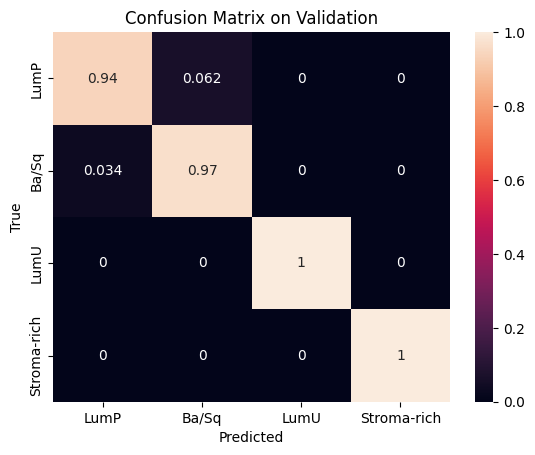

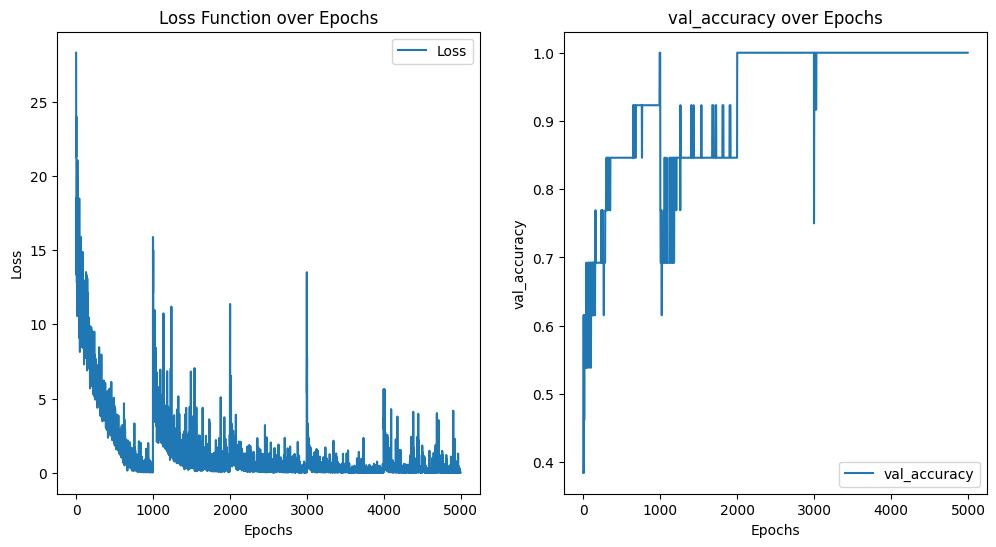

Mean Validation Accuracy: 1.0000, Std Validation Accuracy: 0.0000


In [9]:
# Training phase
similarity_threshold = 0.5

train_val_indices, test_indices = train_test_split(
    range(len(node_features)), 
    test_size=0.2, 
    random_state=1234
)

train_val_data = get_data(train_val_indices, similarity_threshold,num_classes=4)
test_data = get_data(test_indices, similarity_threshold, num_classes=4)

best_model, mean_val_acc = cross_validation_induction(train_val_data, k_folds=5, hidden_channels=20, heads=8, num_epochs=1000)

Test accuracy: 0.8816


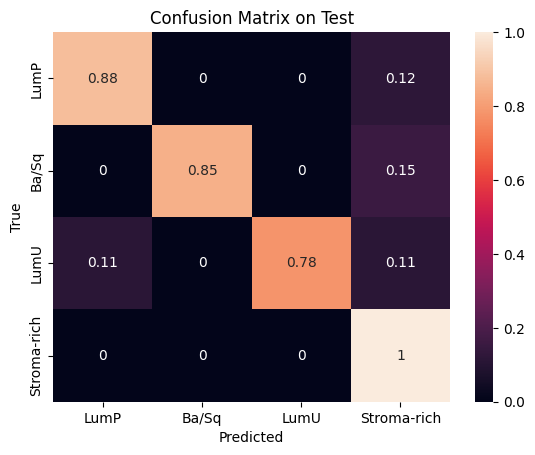

In [10]:
# Testing phase

test_mask = torch.ones(test_data.num_nodes, dtype=torch.bool)
test_acc, y_pred = test(best_model, test_data, test_mask)
y_true = test_data.y[test_mask]

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_true.cpu().tolist(), y_pred.cpu().tolist())
print(f'Test accuracy: {test_acc:.4f}')
classes = ('LumP', 'Ba/Sq', 'LumU', 'Stroma-rich')
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(conf_matrix_normalized, index=classes, columns=classes)  
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test')
plt.show()